## Classificação de Imagens utitlizando Transfer Learning
### Kaggle Dataset Competition: https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview

![dogs-cat](imagens/dogs-cats.png "dogs-cats")

##### verificando a base de dados

In [21]:
import os,random

In [2]:
print(os.listdir('./datasets'))

NameError: name 'os' is not defined

In [3]:
print(os.listdir("./datasets/train")[:10])

NameError: name 'os' is not defined

##### diretorios de imagens

In [4]:
train_dir = './datasets/train'
test_dir = './datasets/test'

**Listas com as imagens de treino e teste**

In [1]:
train_imgs = ['./datasets/train/{}'.format(i) for i in os.listdir(train_dir)]
test_imgs = ['./datasets/test/{}'.format(i) for i in os.listdir(test_dir)]

NameError: name 'os' is not defined

In [26]:
print("Quantidade de imagens de treino:{train} e test:{test}".format(train=len(train_imgs),test=len(test_imgs)))

Quantidade de imagens de treino:400 e test:100


##### aleatorizando as imagens de treinamento

In [27]:
random.shuffle(train_imgs)

In [28]:
print(train_imgs[:10])

['./materiais-apoio-01/datasets/train/dog.157.jpg', './materiais-apoio-01/datasets/train/dog.32.jpg', './materiais-apoio-01/datasets/train/cat.35.jpg', './materiais-apoio-01/datasets/train/cat.27.jpg', './materiais-apoio-01/datasets/train/dog.101.jpg', './materiais-apoio-01/datasets/train/dog.196.jpg', './materiais-apoio-01/datasets/train/dog.19.jpg', './materiais-apoio-01/datasets/train/cat.143.jpg', './materiais-apoio-01/datasets/train/cat.148.jpg', './materiais-apoio-01/datasets/train/cat.131.jpg']


##### importando as bibliotecas necessárias

In [29]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

##### definindo as dimensões das imagens de entrada

In [30]:
nrows = 150
ncolumns = 150
channels = 3

##### função para processamento das imagens e classes

###### efetuando o resize nas imagens e definindo os valores inteiros para as classes

In [31]:
def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for image in list_of_images:
        image_ = Image.open(image)
        X.append(np.asarray(image_.resize((nrows, ncolumns))))
        
        if 'dog' in image:
            y.append(1)
        elif 'cat' in image:
            y.append(0)
    return X,y

In [32]:
X, y = read_and_process_image(train_imgs)

**Transformando a lista de imagens e classes ema Array**

In [33]:
X = np.array(X)
y = np.array(y)

**Visualizando algumas imagens**

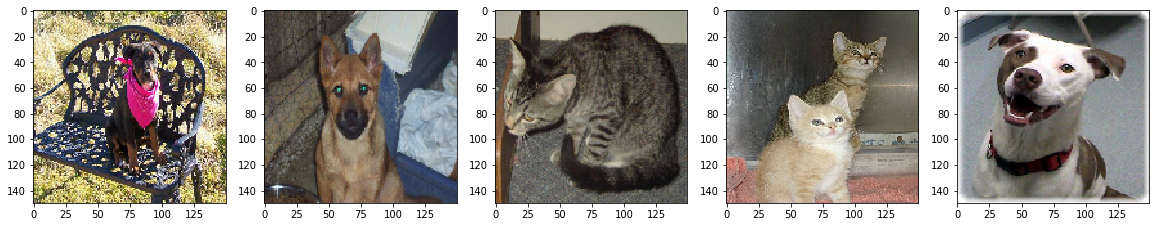

In [34]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i])


##### separando as imagens os dados em treino e test

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

Now lets create our model.



##### instalando as bibliotecas keras e tensorflow

In [36]:
!pip install keras

In [37]:
!pip install tensorflow

##### Importando o modelo pre-treinado ImageNet

In [38]:
# Utilizar uma rede treinada.
from keras.applications import InceptionResNetV2
conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

##### Verificando a arquitetura da rede

In [39]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 74, 74, 32)   96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 74, 74, 32)   0           batch_normalization_204[0][0]    
________________________________________________________________________________

##### importando a biblioteca keras para criar a rede

In [40]:
from keras import layers
from keras import models

##### criando o modelo utilizando a rede convolucional como base

In [41]:
model = models.Sequential()
model.add(conv_base.layers[0])
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

##### Verificando a arquitetura da rede

In [42]:
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 74, 74, 32)   96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 74, 74, 32)   0           batch_normalization_204[0][0]    
________________________________________________________________________________

##### Verificando o numero de pesos a ajustar sem utilizar a rede pré-treinada e após..

In [43]:
print('Número de pesos ajustáveis sem utilizar a rede convolucional:', len(model.trainable_weights))
conv_base.trainable = False
print('Número de pesos ajustáveis utilizando a rede convolucional::', len(model.trainable_weights))

Número de pesos ajustáveis sem utilizar a rede convolucional: 4
Número de pesos ajustáveis utilizando a rede convolucional:: 4


##### Criação dos conjuntos de dados de treino e test utilizando Data Augmentation para prevenir overfitting

In [45]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

ntrain = len(X_train)
nval = len(X_val)
batch_size = 32

train_generator = train_datagen.flow(X_train, y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

##### Criando um modelo binário para treinar as nossas imagens

In [46]:
from keras import optimizers
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=20,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Epoch 1/20
10/10 [==============================] - 2s 202ms/step - loss: 1.8282 - acc: 0.4594 - val_loss: 0.7032 - val_acc: 0.5000
Epoch 2/20
10/10 [==============================] - 2s 181ms/step - loss: 0.8215 - acc: 0.4750 - val_loss: 0.7002 - val_acc: 0.5208
Epoch 3/20
10/10 [==============================] - 2s 179ms/step - loss: 0.7612 - acc: 0.5188 - val_loss: 0.6802 - val_acc: 0.5625
Epoch 4/20
10/10 [==============================] - 2s 185ms/step - loss: 0.8300 - acc: 0.5219 - val_loss: 0.6998 - val_acc: 0.4531
Epoch 5/20
10/10 [==============================] - 2s 195ms/step - loss: 0.7312 - acc: 0.5531 - val_loss: 0.7600 - val_acc: 0.6875
Epoch 6/20
10/10 [==============================] - 2s 174ms/step - loss: 0.8932 - acc: 0.4656 - val_loss: 0.7560 - val_acc: 0.5208
Epoch 7/20
10/10 [==============================] - 2s 181ms/step - loss: 0.7986 - acc: 0.5281 - val_loss: 0.7458 - val_acc: 0.5156
Epoch 8/20
10/10 [==============================] - 2s 192ms/step - loss: 0.

##### Salvando o modelo e pesos em disco

In [47]:
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

##### Salvando o arquivo de historico em disco

In [49]:
import pickle

In [50]:
f = open('history.pckl', 'wb')
pickle.dump(history.history, f)
f.close()

##### Carregando o arquivo de historico a partir do disco

In [51]:
f = open('history.pckl', 'rb')
historico = pickle.load(f)
f.close()

##### Visualizando as métricas do modelo

In [53]:
import matplotlib.pyplot as plt

acc = historico['acc']
val_acc = historico['val_acc']
loss = historico['loss']
val_loss = historico['val_loss']
epochs = range(1, len(acc) + 1)

##### Acurácia de treino e teste

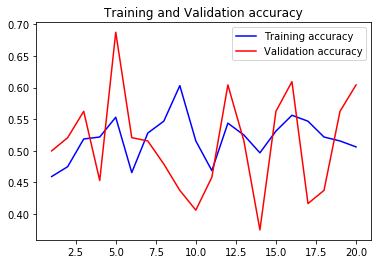

In [54]:
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

##### Função de perda de treino e teste

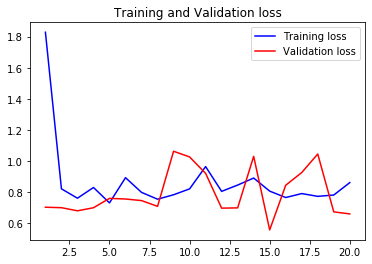

In [55]:
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

##### Função para suavizar os dados e melhorar a visualização

In [56]:
def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

##### Acurácia de treino e teste

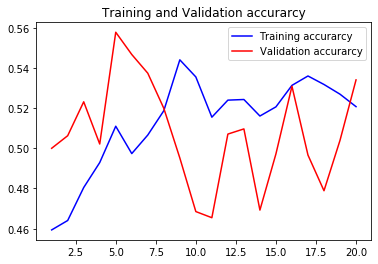

In [57]:
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accurarcy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.show()

##### Testando os resultados de predição

###### Selecionando 10 imagens a partir do conjunto de teste

In [58]:
X_test, y_test = read_and_process_image(test_imgs[0:10])

###### transformando a lista de imagens em array e aplicando a rescala dos pixels

In [59]:
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

###### plotando as imagens e suas respectivas classes

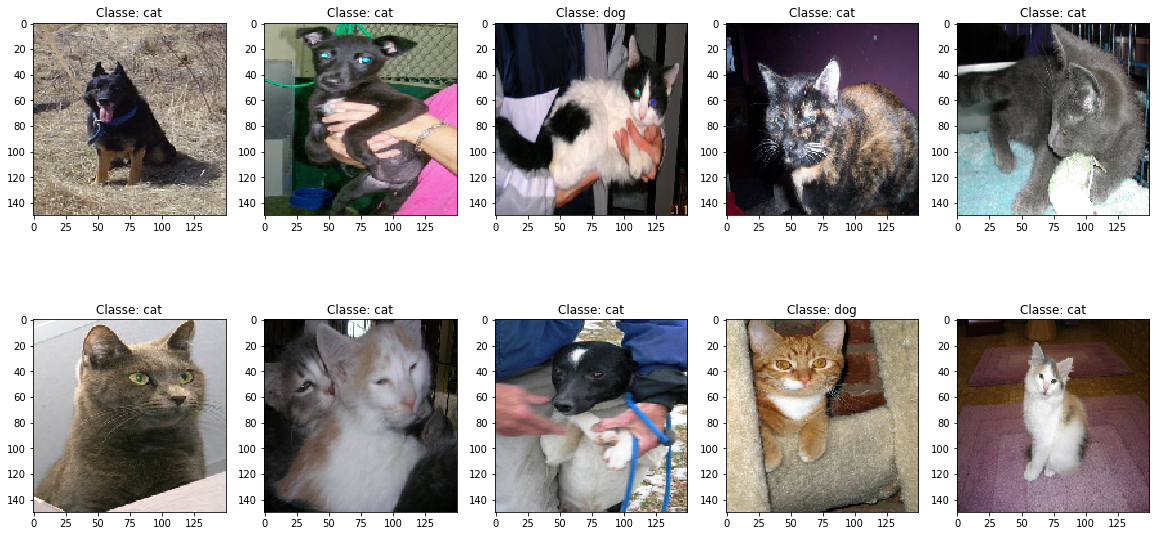

In [60]:
i = 0
columns = 5
text_labels = []

plt.figure(figsize=(20,10))

for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict_classes(batch)
    if pred == 1:
        text_labels.append('dog')
    else:
        text_labels.append('cat')
    
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('Classe: ' + text_labels[i])
    
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()